#Imports

In [1]:
!pip install ucimlrepo
!pip install gower
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import gower

from google.colab import files

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import pearsonr, fisher_exact, chi2_contingency
from scipy.special import expit, softmax

from itertools import combinations, product

import seaborn as sns

# Helper Functions

## Split Data

In [2]:
# function to split our data
def split_data(X, y, train_size=0.66, valid_size=0.0, test_size=0.34):

    # split data
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(
        X, y, test_size=test_size, random_state=1234
    )

    if valid_size > 0:
        train_ratio = train_size / (train_size + valid_size)

        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train_valid, y_train_valid, test_size=1 - train_ratio, random_state=42
        )

        return X_train, X_valid, X_test, y_train, y_valid, y_test

    return X_train_valid, X_test, y_train_valid, y_test

## Compare Models

In [3]:
# function used to compare models
def compare(linear_model, logistic_model, X_test, y_test):
    # linear regression
    y_pred_linear = linear_model.predict(X_test)

    y_pred_linear_prob = expit(y_pred_linear)
    y_pred_linear_class = (y_pred_linear_prob >= 0.5).astype(int)

    y_pred_logistic_prob = logistic_model.predict(X_test)

    y_pred_logistic_class = (y_pred_logistic_prob >= 0.5).astype(int)

    #auroc
    auroc_linear = roc_auc_score(y_test, y_pred_linear_prob)
    auroc_logistic = roc_auc_score(y_test, y_pred_logistic_prob)

    # accuracy
    acc_linear = accuracy_score(y_test, y_pred_linear_class)
    acc_logistic = accuracy_score(y_test, y_pred_logistic_class)

    # results
    print("=== Model Comparison ===")
    print(f"Linear Regression - Accuracy: {acc_linear:.4f}, AUROC: {auroc_linear:.4f}")
    print(f"Logistic Regression - Accuracy: {acc_logistic:.4f}, AUROC: {auroc_logistic:.4f}")

    # roc curves
    fpr_linear, tpr_linear, _ = roc_curve(y_test, y_pred_linear_prob)
    fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_logistic_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_linear, tpr_linear, label=f"Linear Regression (AUROC = {auroc_linear:.4f})", linestyle='-')
    plt.plot(fpr_logistic, tpr_logistic, label=f"Logistic Regression (AUROC = {auroc_logistic:.4f})", linestyle='-')
    plt.plot([0, 1], [0, 1], color="gray", linestyle="dashed", linewidth=1)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve Comparison: Linear vs Logistic Regression")
    plt.legend()
    plt.grid()
    plt.show()

    print("=== Test Accuracies ===")
    print(f"Linear Regression - Accuracy: {acc_linear:.4f}")
    print(f"Logistic Regression - Accuracy: {acc_logistic:.4f}")

    #acc_linear, auroc_linear, acc_logistic, auroc_logistic
    return None

In [50]:
def compare2(linear_model, logistic_model, accuracy_mlr, X_test, y_test):
    # convert one-hot encoded y_test to class labels
    y_test_labels = np.argmax(y_test, axis=1)

    # linear regression
    y_pred_linear = linear_model.predict(X_test)

    if y_pred_linear.ndim == 1:
        y_pred_linear = y_pred_linear[:, np.newaxis]

    # softmax
    y_pred_linear_prob = softmax(y_pred_linear, axis=1)
    y_pred_linear_class = np.argmax(y_pred_linear_prob, axis=1)

    y_pred_logistic_prob = logistic_model.predict_proba(X_test)
    y_pred_logistic_class = np.argmax(y_pred_logistic_prob, axis=1)

    #auroc
    auroc_linear = roc_auc_score(y_test, y_pred_linear_prob)
    auroc_logistic = roc_auc_score(y_test, y_pred_logistic_prob)

    # accuracy
    acc_linear = accuracy_score(y_test_labels, y_pred_linear_class)
    acc_logistic = accuracy_score(y_test_labels, y_pred_logistic_class)


    # results
    print("=== Model Comparison ===")
    print(f"Linear Regression - Accuracy: {accuracy_mlr:.4f}, AUROC: {auroc_linear:.4f}")
    print(f"Logistic Regression - Accuracy: {acc_logistic:.4f}, AUROC: {auroc_logistic:.4f}")

    # acc_linear, auroc_linear, acc_logistic, auroc_logistic
    return None

## Compare Coeffs

In [5]:
# function used to compare coeffs
def compare_coefficients(log_reg, lin_reg, feature_names, dataset_name):
    logistic_coefs = log_reg.w[:-1] if hasattr(log_reg, 'w') else log_reg.W[:-1]
    linear_coefs = lin_reg.W[:-1] if hasattr(lin_reg, 'W') else lin_reg.w[:-1]

    # df
    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Logistic Regression Coef": logistic_coefs,
        "Linear Regression Coef": linear_coefs
    })

    coef_df = coef_df.set_index("Feature").sort_values(by="Logistic Regression Coef", key=np.abs, ascending=False)

    # plot
    fig, ax = plt.subplots(figsize=(10, 6))
    coef_df.plot(kind="barh", ax=ax, width=0.8)
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title(f"Comparison of Logistic vs. Linear Regression Coefficients\n({dataset_name})")
    plt.legend(["Logistic Regression", "Linear Regression"])
    plt.grid(True)
    plt.show()

    # print
    print(f"\nTop Features in {dataset_name}:")
    print(coef_df.head(5))

## Heatmap Graph

In [6]:
# function used to graph heatmap
def plot_heatmap(W, feature_names, class_names, title):
    if W.shape[0] > len(feature_names):
          W = W[:-1]  # Remove last row (bias term)

    # convert to DataFrame for visualization
    coef_df = pd.DataFrame(W, index=feature_names, columns=class_names)

    # plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(coef_df, annot=True, cmap="Reds", center=0, fmt=".2f", linewidths=0.5)
    plt.xlabel("Classes")
    plt.ylabel("Features")
    plt.title(title)
    plt.show()

# Task 1: Acquire, preprocess, and analyze the data

## 1.1 (Breast Cancer)

### Load Data (1)

In [7]:
#         UPLOADING DATA & REMOVING NULL/USELESS FEATURES

# BREAST CANCER DATA SET
uploaded = files.upload()
wdbc_df = pd.read_csv("wdbc.data", header=None)

# columns in dataset
wdbc_columns = [
    "ID", "Diagnosis", "Radius", "Texture", "Perimeter", "Area", "Smoothness", "Compactness", "Concavity",
    "Concave_Points", "Symmetry", "Fractal_Dimension","Radius_2", "Texture_2", "Perimeter_2", "Area_2", "Smoothness_2",
    "Compactness_2", "Concavity_2", "Concave_Points_2", "Symmetry_2","Fractal_Dimension_2", "Radius_3", "Texture_3", "Perimeter_3",
    "Area_3", "Smoothness_3", "Compactness_3", "Concavity_3","Concave_Points_3", "Symmetry_3", "Fractal_Dimension_3"
]

wdbc_df.columns = wdbc_columns
print(wdbc_df.head())

Saving wdbc.data to wdbc (3).data
         ID Diagnosis  Radius  Texture  Perimeter    Area  Smoothness  \
0    842302         M   17.99    10.38     122.80  1001.0     0.11840   
1    842517         M   20.57    17.77     132.90  1326.0     0.08474   
2  84300903         M   19.69    21.25     130.00  1203.0     0.10960   
3  84348301         M   11.42    20.38      77.58   386.1     0.14250   
4  84358402         M   20.29    14.34     135.10  1297.0     0.10030   

   Compactness  Concavity  Concave_Points  ...  Radius_3  Texture_3  \
0      0.27760     0.3001         0.14710  ...     25.38      17.33   
1      0.07864     0.0869         0.07017  ...     24.99      23.41   
2      0.15990     0.1974         0.12790  ...     23.57      25.53   
3      0.28390     0.2414         0.10520  ...     14.91      26.50   
4      0.13280     0.1980         0.10430  ...     22.54      16.67   

   Perimeter_3  Area_3  Smoothness_3  Compactness_3  Concavity_3  \
0       184.60  2019.0        0.

### Standardize and Compute Simple Regression Coeff (2)

In [8]:
# BREAST CANCER DATA SET
scaler = StandardScaler()
encoder = OneHotEncoder()

# set x to predictor variables (except ID)
X_cancer = wdbc_df.drop(columns=["ID", "Diagnosis"])
# set y to response variable
y_cancer = wdbc_df["Diagnosis"].map({"M": 1, "B": 0})

# features
X_wdbc = wdbc_df.drop(columns=["Diagnosis"])
# scale
X_wdbc_standardized = scaler.fit_transform(X_cancer)

# target (M = Malignant, B = Benign)
y_wdbc = wdbc_df["Diagnosis"]
# one-hot encode target (M = Malignant, B = Benign)
Y_wdbc_encoded = encoder.fit_transform(y_cancer.values.reshape(-1, 1))

# simple regression
W_wdbc = X_wdbc_standardized.T @ Y_wdbc_encoded / X_wdbc_standardized.shape[0]

### Rank Features and Plot (3)

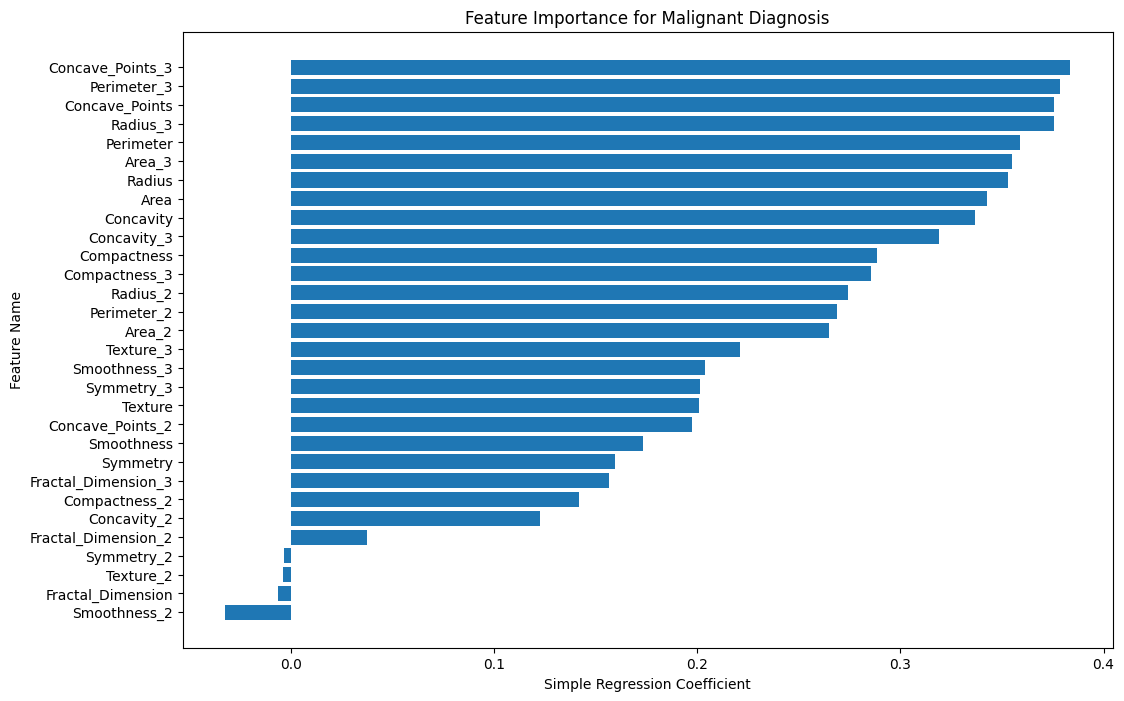

In [9]:
# Task 4: Run experiments (1)

# change to 0 for Benign
class_to_plot = 1
features = np.array(X_cancer.columns)
coefficients = W_wdbc[:, class_to_plot]

# sort features by coefficient values in descending order
sorted_indices = np.argsort(coefficients)[::-1]
features_sorted = features[sorted_indices]
coefficients_sorted = coefficients[sorted_indices]

# plot
plt.figure(figsize=(12, 8))
plt.barh(np.arange(len(features_sorted)), coefficients_sorted)
plt.xlabel("Simple Regression Coefficient")
plt.ylabel("Feature Name")
plt.title("Feature Importance for Malignant Diagnosis")
plt.yticks(np.arange(len(features_sorted)), features_sorted)
plt.gca().invert_yaxis()
plt.show()

### Research (4)

The top 4 features:

    Concave_Points_3, the number of concave portions of the contour in the 3rd plane of a 3-dimensional space. Concave points "are vital in malignancy prediction" and "the presence of more concave points indicates a more irrgular shape of a nucleus" (https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-023-02142-2)
    
    Perimeter_3, perimeter of cell nucleus. Perimeter is essential as large perimeter values "are vital in malignancy prediction" (https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-023-02142-2)
    
    Concave_Points, the number of concave portions of the contour in the 1st plane of a 3-dimensional space. Concave points "are vital in malignancy prediction" and "the presence of more concave points indicates a more irrgular shape of a nucleus" (https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-023-02142-2)
    
    Radius_3, radius of cell nucleus.Radius is essential as "higher value of the radius of the cell image indicates that the breast cancer has spread to other parts of the human body". So there is a positive correlation (https://pmc.ncbi.nlm.nih.gov/articles/PMC8612371/#:~:text=The%20higher%20value%20of%20the,one%20diagnosis%20over%20the%20other.)


The bottom 3 features:

    Symmetry_2, symmetry of the cell nucleus in space of 2nd dimension. Symmetry of the cell nucleus "do not indicate a particular preference of one diagniosis" (malignant or benign) over the other (https://pmc.ncbi.nlm.nih.gov/articles/PMC8612371/#:~:text=The%20higher%20value%20of%20the,one%20diagnosis%20over%20the%20other.)
    
    Texture_2, standard deviation of gray scale values in 2nd dimension. Texture of the cell nucleus in the 2nd dimension does not seem to have a preference of one diagnosis over the other
    
    Fractal_Dimension, coastline approx. Fractal dimension of the cell nucleus (do not indicate a particular preference of one diagnosis over the other) (https://pmc.ncbi.nlm.nih.gov/articles/PMC8612371/#:~:text=The%20higher%20value%20of%20the,one%20diagnosis%20over%20the%20other.)

### Remove Features (5)

In [10]:
# drop unwanted columns (ID, Diagnosis, and additional features with low importance)
bc_features = wdbc_df.drop(columns=["ID", "Diagnosis", "Symmetry_2", "Texture_2", "Fractal_Dimension", "Smoothness_2", "Fractal_Dimension_2"])
bc_target = y_cancer

## 1.2 (Penguin)

### Load Data (1)

In [11]:
# PENGUIN DATA SET
uploaded = files.upload()
penguin_df = pd.read_csv("penguins_size.csv")

contingency_table = pd.crosstab(penguin_df['sex'], penguin_df['species'])

 #chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Test Statistic: {chi2:.4f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-Value: {p:.4f}")

    # determine significance
if p < 0.05:
    print("Result: There is a significant association between sex and species in the Penguin dataset.")
else:
    print("Result: There is no significant association between sex and species in the Penguin dataset.")

# drop island and sex
penguin_df = penguin_df.drop(columns = ["island", "sex"])

# drop null values
penguin_df = penguin_df.dropna().reset_index(drop = True)

# print first 5 rows
print(penguin_df.head())

Saving penguins_size.csv to penguins_size (3).csv
Chi-Square Test Statistic: 1.8372
Degrees of Freedom: 4
P-Value: 0.7657
Result: There is no significant association between sex and species in the Penguin dataset.
  species  culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
0  Adelie              39.1             18.7              181.0       3750.0
1  Adelie              39.5             17.4              186.0       3800.0
2  Adelie              40.3             18.0              195.0       3250.0
3  Adelie              36.7             19.3              193.0       3450.0
4  Adelie              39.3             20.6              190.0       3650.0


### Standardize and Compute Simple Regression Coeff (2)

In [12]:
# PENGUIN DATA SET

# Standardize and encode features
scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False)

# covariates
X_penguin = penguin_df.drop(columns=["species"])
# target
y_penguin = penguin_df["species"]

# compute simple regression coeffs
X_penguin_standardized = scaler.fit_transform(X_penguin)
Y_penguin_encoded = encoder.fit_transform(y_penguin.values.reshape(-1, 1))
W_penguin = X_penguin_standardized.T @ Y_penguin_encoded / X_penguin_standardized.shape[0]

### Rank Features and Plot (3)

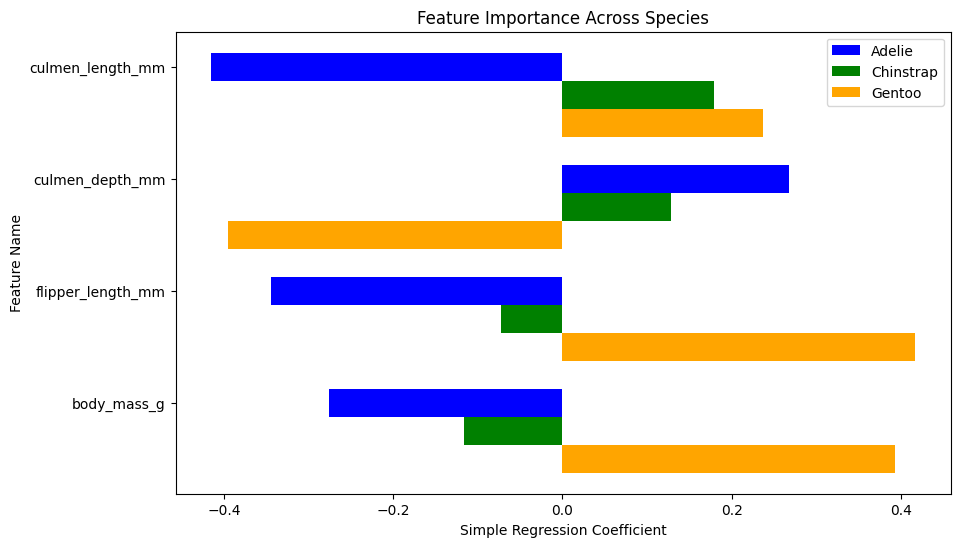

In [13]:
# Task 4: Run experiments (1)

# plot all classes on a single grouped bar graph
features = X_penguin.columns
species = encoder.categories_[0]
x = np.arange(len(features))

plt.figure(figsize=(10, 6))
colors = ["blue", "green", "orange"]

for class_idx, class_name in enumerate(species):
    plt.barh(x + class_idx * 0.25, W_penguin[:, class_idx], 0.25, label=class_name, color=colors[class_idx])

plt.xlabel("Simple Regression Coefficient")
plt.ylabel("Feature Name")
plt.title("Feature Importance Across Species")
plt.yticks(x, features)
plt.legend()
plt.gca().invert_yaxis()
plt.show()

### Research (4)

Adelie Penguins

    Top feature is culmen length. This is because Adelie penguins have much higher average culmen lengths than the other two species of penguins. So culmen length is a good covaraiate to analyze to identify Adelie penguins.

    Bottom feature is body mass. This is because body mass is not a good identifier to classify species of Adelie penguins as other species seem to have similar body mass values.

Chinstrap Penguins

    Top feature is culmen length. This is because Chinstrap penguins have much lower average culmen lengths than the other two species of penguins. So culmen length is a good covaraiate to analyze to identify Chinstrap penguins.
    
    Bottom feature is flipper length. This is because flipper length is not a good identifier to classify species of Chinstrap penguins as other species seem to have similar flipper length values.

Gentoo Penguins

    Top feature is flipper length. This is because Gentoo penguins have much higher average flipper length than the other two species of penguins. So flipper length is a good covaraiate to analyze to identify Chinstrap penguins.
    
    Bottom feature is culmen length. This is because culmen length is not a good identifier to classify species of Adelie penguins as other species seem to have similar culmen length values.

### Remove Features (5)

We removed no features

# Task 2: Implement Linear Regression Models

## Implementing Models

### Multiple Linear Regression Model

In [14]:
# from github
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias


    def fit(self, X, Y):
        if X.ndim == 1:
            X = X[:, None]
        N = X.shape[0]
        if self.add_bias:
            X = np.column_stack([X, np.ones(N)])

        self.W = np.linalg.pinv(X.T @ X) @ X.T @ Y
        return self


    def predict_class(self, X):
      return np.argmax(self.predict(X), axis=1)


    def predict(self, X):
        N = X.shape[0]
        if self.add_bias:
            X = np.column_stack([X, np.ones(N)])

        return X @ self.W


    def accuracy(self, X, Y_true):
      Y_pred = self.predict(X)

      return np.mean((Y_true - Y_pred) ** 2)

### Implementing Multivariate Linear Regression Model

In [15]:
# multivariate linear regression
class MultivariateLinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        self.W = None


    def fit(self, X, Y):
        if X.ndim == 1:
            X = X[:, None]

        N = X.shape[0]
        if self.add_bias:
            X = np.column_stack([X, np.ones(N)])

        self.W = np.linalg.pinv(X.T @ X) @ X.T @ Y
        return self


    def predict(self, X):
        if X.ndim == 1:
            X = X[:, None]

        N = X.shape[0]
        if self.add_bias:
            X = np.column_stack([X, np.ones(N)])

        scores = X @ self.W

        return np.argmax(scores, axis=1)


    def accuracy(self, X, Y_true):
        Y_pred_class = self.predict(X)
        Y_true_class = np.argmax(Y_true, axis=1)
        return np.mean(Y_true_class == Y_pred_class)

## Breast Cancer (Multiple Linear Regression)

In [16]:
# Task 4: Run experiments (2)

X_train, X_test, y_train, y_test = split_data(X_cancer, y_cancer, train_size=0.66, test_size=0.34)

# initialize and train linear regression model
lin_reg = LinearRegression()
# train on training data
lin_reg.fit(X_train, y_train)

# predict
y_test_pred = lin_reg.predict(X_test)

# accuracy
mse_test = lin_reg.accuracy(X_test, y_test)
print(f"Linear Regression - Test MSE: {mse_test:.4f}")

Linear Regression - Test MSE: 0.0684


## Penguin (Multivariate Linear Regression)

In [31]:
# Task 4: Run experiments (2)

X_train_p, X_valid_p, X_test_p, Y_train_p, Y_valid_p, Y_test_p = split_data(X_penguin_standardized, Y_penguin_encoded, train_size=0.6, valid_size=0.2, test_size=0.2)

# Train the model
multi_lin_reg = MultivariateLinearRegression()
multi_lin_reg.fit(X_train_p, Y_train_p)

# Get predictions and compute accuracy
Y_test_pred_class = multi_lin_reg.predict(X_test_p)
Y_test_true_class = np.argmax(Y_test_p, axis=1)

accuracy_mlr = accuracy_score(Y_test_true_class, Y_test_pred_class)
print(f"Multivariate Linear Regression - Test Accuracy: {accuracy_mlr:.4f}")

Multivariate Linear Regression - Test Accuracy: 1.0000


# Task 3: Implement Logistic and Multiclass Classifiers

## Implementing Models

### Logistic Regression Model

In [18]:
def logistic(z):
        z = np.clip(z, -500, 500)  # added this for overflow errors
        return 1 / (1 + np.exp(-z))

# from github
class LogisticRegression:
    def __init__(self,
                 add_bias=True,
                 learning_rate=0.1,
                 epsilon=1e-4,
                 max_iters=10000,
                 verbose=False):

        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = int(max_iters)
        self.verbose = verbose
        self.w = None
        self.loss_history = []

    def sigmoid(self, z):
        return expit(z)


    def compute_loss(self, X, y, w=None):
        if w is None:
            w = self.w

        y_hat = self.sigmoid(X @ w)

        y_hat = np.clip(y_hat, 1e-9, 1 - 1e-9)

        loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        return loss


    def gradient(self, X, y, w=None):
        if w is None:
            w = self.w
        m = X.shape[0]

        y_hat = self.sigmoid(X @ w)

        grad = (X.T @ (y_hat - y)) / m
        return grad


    def fit(self, X, y):
        if X.ndim == 1:
            X = X[:, None]

        if self.add_bias:
            X = np.column_stack([X, np.ones(X.shape[0])])

        self.w = np.zeros(X.shape[1])

        self.loss_history = []
        for t in range(self.max_iters):
            grad = self.gradient(X, y)

            self.w -= self.learning_rate * grad

            loss = self.compute_loss(X, y)
            self.loss_history.append(loss)

            if self.verbose and t % 500 == 0:
                print(f"Iteration {t}, Loss = {loss:.6f}")


    def predict(self, X):
        if X.ndim == 1:
            X = X[:, None]
        if self.add_bias:
            X = np.column_stack([X, np.ones(X.shape[0])])

        return self.sigmoid(X @ self.w)


    def plot_loss(self):
        plt.plot(self.loss_history, label="Training Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Cross-Entropy Loss")
        plt.title("Logistic Regression Training Loss")
        plt.legend()
        plt.show()


    def check_gradient(self, X, y, epsilon=1e-5):
        if X.ndim == 1:
            X = X[:, None]
        if self.add_bias:
            X = np.column_stack([X, np.ones(X.shape[0])])

        original_w = self.w.copy()

        analytical_grad = self.gradient(X, y, w=original_w)

        numerical_grad = np.zeros_like(original_w)

        for i in range(len(original_w)):
            w_plus = original_w.copy()
            w_minus = original_w.copy()

            w_plus[i] += epsilon
            w_minus[i] -= epsilon

            loss_plus = self.compute_loss(X, y, w=w_plus)

            loss_minus = self.compute_loss(X, y, w=w_minus)

            numerical_grad[i] = (loss_plus - loss_minus) / (2 * epsilon)

        self.w = original_w

        diff = np.abs(numerical_grad - analytical_grad) / (np.abs(numerical_grad) + np.abs(analytical_grad) + 1e-9)

        print("\nGradient Check Debug:")
        print(f"Analytical Grad:\n{analytical_grad}")
        print(f"Numerical Grad:\n{numerical_grad}")
        print(f"Max Relative Gradient Difference: {np.max(diff):.6e}")

        if np.max(diff) < 1e-5:
            print("Gradient check PASSED (difference < 1e-5).")
        else:
            print("Gradient check FAILED (difference > 1e-5). Check your computations.")

        return diff

### Multiclass Logistic Regression Model

In [19]:
# from github
class MultinomialLogistic:
    def __init__(self, n_features, n_classes, learning_rate=0.005, tolerance=1e-4, max_iters=1000, verbose=False):
        self.W = np.random.randn(n_features, n_classes) * 0.01
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.max_iters = max_iters
        self.verbose = verbose
        self.loss_history = []


    def softmax(self, logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)


    def predict_proba(self, X):
        logits = np.dot(X, self.W)
        return self.softmax(logits)


    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


    def compute_loss(self, X, Y):
        epsilon = 1e-9
        P = self.predict_proba(X)
        return -np.mean(np.sum(Y * np.log(P + epsilon), axis=1))


    def compute_gradient(self, X, Y):
        N = X.shape[0]
        P = self.predict_proba(X)
        return np.dot(X.T, (P - Y)) / N


    def fit(self, X, Y, X_valid=None, Y_valid=None):
        for i in range(self.max_iters):
            grad = self.compute_gradient(X, Y)
            self.W -= self.learning_rate * grad

            loss_train = self.compute_loss(X, Y)
            self.loss_history.append(loss_train)

            if X_valid is not None and Y_valid is not None:
                loss_valid = self.compute_loss(X_valid, Y_valid)

            if np.linalg.norm(grad) < self.tolerance:
                print(f"Converged at iteration {i} with gradient norm {np.linalg.norm(grad):.6f}")
                break


    def plot_loss(self):
        if not self.loss_history:
            print("Error: No loss history recorded. Did you call fit()?")
            return

        plt.plot(self.loss_history, label="Training Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Cross-Entropy Loss")
        plt.title("Logistic Regression Training Loss")
        plt.legend()
        plt.show()


    def check_gradient(self, X, Y):
      N, C = Y.shape
      D = X.shape[1]
      diff = np.zeros((D, C))
      W_copy = self.W.copy()

      print("\nStarting Gradient Checking...\n")

      for i in range(D):
          for j in range(C):
              epsilon = np.zeros((D, C))
              epsilon[i, j] = np.random.rand() * 1e-4

              self.W = W_copy + epsilon
              J1 = self.compute_loss(X, Y)

              self.W = W_copy - epsilon
              J2 = self.compute_loss(X, Y)

              self.W = W_copy

              numeric_grad = (J1 - J2) / (2 * epsilon[i, j])

              derived_grad = self.compute_gradient(X, Y)[i, j]

              numerator = np.square(derived_grad - numeric_grad).sum()
              denominator = np.square(derived_grad + numeric_grad).sum() + 1e-8
              diff[i, j] = numerator / denominator

              print(f"Feature {i}, Class {j}:")
              print(f"  Numeric Grad: {numeric_grad:.6f}")
              print(f"  Derived Grad: {derived_grad:.6f}")
              print(f"  Difference: {diff[i, j]:.8f}\n")

      total_diff = diff.sum()
      max_diff = np.max(diff)

      print("\nGradient Checking Completed.")
      print(f"Total Gradient Difference: {total_diff:.8f}")
      print(f"Maximum Gradient Difference: {max_diff:.8f}")

      if total_diff < 1e-5:
          print("\nGradient check PASSED (difference < 1e-5).")
      else:
          print("\nGradient check FAILED (difference > 1e-5). Check your computations!")

      return total_diff

## Breast Cancer (Logistic Regression)


Performing Gradient Checking...

Gradient Check Debug:
Analytical Grad:
[-3.24457123e-02 -2.26130799e-01 -3.23358997e-01 -4.10601326e-01
 -8.85550667e-04 -3.80445102e-03 -4.85456837e-03 -1.54891354e-03
 -1.73923943e-03 -5.64058075e-04  2.50461325e-03 -1.72781135e-02
 -2.84331285e-03  1.95748540e-01 -8.66364052e-05 -1.39027556e-03
 -1.57514132e-03 -2.86136986e-04 -2.77889459e-04 -1.49489872e-04
 -2.29590575e-02 -3.79160256e-01 -4.62785175e-01  4.33168840e-01
 -1.62518301e-03 -1.44047263e-02 -1.68646959e-02 -3.98198111e-03
 -3.69016258e-03 -1.80366286e-03 -3.23487885e-03]
Numerical Grad:
[-3.24457122e-02 -2.26130798e-01 -3.23358967e-01 -4.10599036e-01
 -8.85550674e-04 -3.80445102e-03 -4.85456837e-03 -1.54891354e-03
 -1.73923944e-03 -5.64058067e-04  2.50461325e-03 -1.72781135e-02
 -2.84331284e-03  1.95748540e-01 -8.66364119e-05 -1.39027556e-03
 -1.57514132e-03 -2.86136986e-04 -2.77889453e-04 -1.49489870e-04
 -2.29590573e-02 -3.79160255e-01 -4.62785127e-01  4.33174680e-01
 -1.62518301e-03

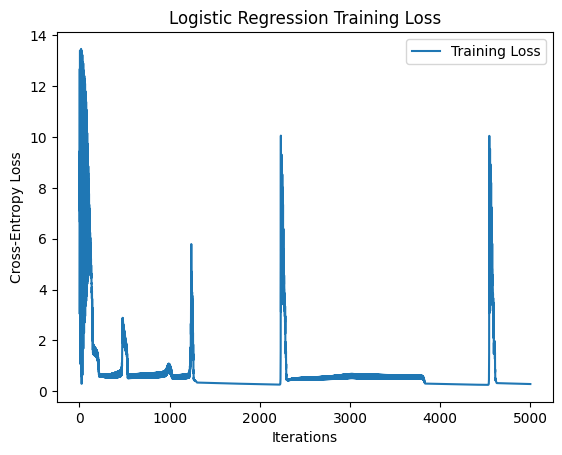

In [20]:
# Task 4: Run experiments (3)
# using all features

# splitting data
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X_cancer, y_cancer, train_size=0.33, valid_size=0.33, test_size=0.34)

# various learning rates
learning_rates = [0.0001, 0.01, 0.1, 1.0]
best_auroc = 0
best_weights = None
best_lr = None
auroc_history = {}

# training logistic with different weight
for lr in learning_rates:
    log_reg = LogisticRegression(learning_rate=lr, max_iters=5000, verbose=False)
    log_reg.fit(X_train, y_train)

    X_valid_bias = np.column_stack([X_valid, np.ones(X_valid.shape[0])]) if log_reg.add_bias else X_valid
    y_valid_pred_prob = logistic(np.dot(X_valid_bias, log_reg.w))

    auroc_valid = roc_auc_score(y_valid, y_valid_pred_prob)
    auroc_history[lr] = auroc_valid

    # keeping track of best weight
    if auroc_valid > best_auroc:
        best_auroc = auroc_valid
        best_weights = log_reg.w.copy()
        best_lr = lr

# logistic regression with best weight
log_reg = LogisticRegression(learning_rate=best_lr, max_iters=5000, verbose=False)
log_reg.w = best_weights

# auroc on test set
X_test_bias = np.column_stack([X_test, np.ones(X_test.shape[0])]) if log_reg.add_bias else X_test
y_test_pred_prob = logistic(np.dot(X_test_bias, log_reg.w))
auroc_test = roc_auc_score(y_test, y_test_pred_prob)

# linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

log_reg.fit(X_train, y_train)

# gradient checking
print("\nPerforming Gradient Checking...")
log_reg.check_gradient(X_train, y_train)

# training loss curve
log_reg.plot_loss()


Performing Gradient Checking...

Gradient Check Debug:
Analytical Grad:
[-0.01780416 -0.00632289 -0.00501388 -0.00183682 -0.00517556  0.00516688]
Numerical Grad:
[-0.01780416 -0.00632289 -0.00501388 -0.00183682 -0.00517556  0.00516688]
Max Relative Gradient Difference: 6.466928e-11
Gradient check PASSED (difference < 1e-5).


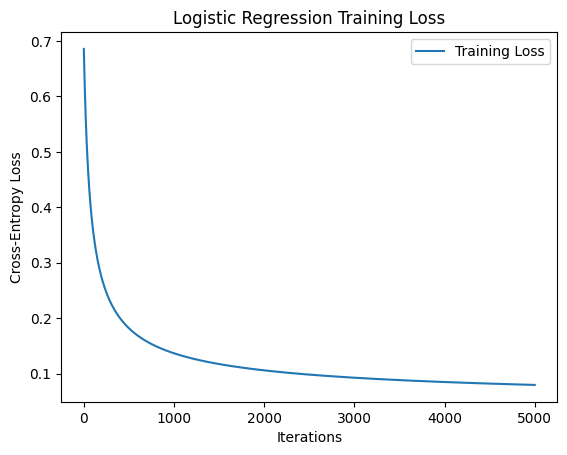

In [21]:
# Task 4: Run experiments (3)
# using top 5 features

top_5_features = ["Concave_Points_3", "Perimeter_3", "Radius_3", "Perimeter", "Area_3"]
X_cancer_top5 = wdbc_df[top_5_features].copy()

# standardize
X_cancer_top5_standardized = StandardScaler().fit_transform(X_cancer_top5)

# back to data frame
X_cancer_top5_df = pd.DataFrame(X_cancer_top5_standardized, columns=top_5_features)

# target
X_cancer_top5_df["Diagnosis"] = y_cancer.reset_index(drop=True)

# splitting data
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(
    X_cancer_top5_df.drop(columns=["Diagnosis"]),
    X_cancer_top5_df["Diagnosis"],
    train_size=0.33, valid_size=0.33, test_size=0.34
)

# learning rates
learning_rates = [0.0001, 0.01, 0.1, 1.0]
best_auroc = 0
best_weights = None
best_lr = None
auroc_history = {}

# train logistic regression with different learning rates
for lr in learning_rates:
    log_reg_5 = LogisticRegression(learning_rate=lr, max_iters=5000, verbose=False)
    log_reg_5.fit(X_train, y_train)

    X_valid_bias = np.column_stack([X_valid, np.ones(X_valid.shape[0])]) if log_reg_5.add_bias else X_valid
    y_valid_pred_prob = logistic(np.dot(X_valid_bias, log_reg_5.w))

    auroc_valid = roc_auc_score(y_valid, y_valid_pred_prob)
    auroc_history[lr] = auroc_valid

    # best weights
    if auroc_valid > best_auroc:
        best_auroc = auroc_valid
        best_weights = log_reg_5.w.copy()
        best_lr = lr

log_reg_5 = LogisticRegression(learning_rate=best_lr, max_iters=5000, verbose=False)
log_reg_5.w = best_weights

lin_reg_5 = LinearRegression()
lin_reg_5.fit(X_train, y_train)

log_reg_5.fit(X_train, y_train)

# Perform gradient checking
print("\nPerforming Gradient Checking...")
log_reg_5.check_gradient(X_train, y_train)

# Plot training loss curve
log_reg_5.plot_loss()

## Penguin (Multiclass Logistic Regression)

Converged at iteration 4794 with gradient norm 0.001000
Converged at iteration 4794 with gradient norm 0.001000

Performing Gradient Checking...

Starting Gradient Checking...

Feature 0, Class 0:
  Numeric Grad: 0.050937
  Derived Grad: 0.050937
  Difference: 0.00000000

Feature 0, Class 1:
  Numeric Grad: -0.047829
  Derived Grad: -0.047829
  Difference: 0.00000000

Feature 0, Class 2:
  Numeric Grad: -0.003108
  Derived Grad: -0.003108
  Difference: 0.00000000

Feature 1, Class 0:
  Numeric Grad: -0.031578
  Derived Grad: -0.031578
  Difference: 0.00000000

Feature 1, Class 1:
  Numeric Grad: -0.002983
  Derived Grad: -0.002983
  Difference: 0.00000000

Feature 1, Class 2:
  Numeric Grad: 0.034562
  Derived Grad: 0.034562
  Difference: 0.00000000

Feature 2, Class 0:
  Numeric Grad: 0.009786
  Derived Grad: 0.009786
  Difference: 0.00000000

Feature 2, Class 1:
  Numeric Grad: 0.013623
  Derived Grad: 0.013623
  Difference: 0.00000000

Feature 2, Class 2:
  Numeric Grad: -0.023409
 

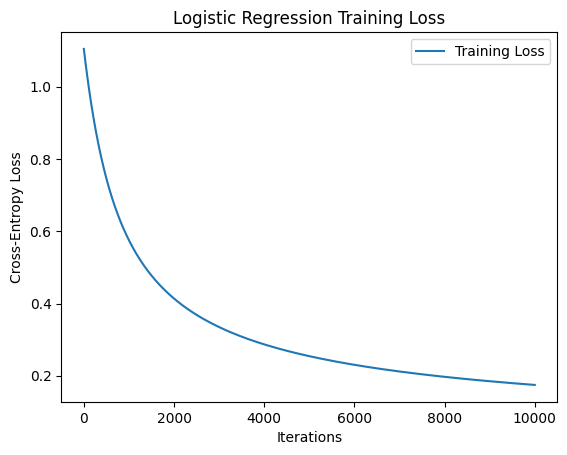

In [22]:
# Task 4: Run experiments (3)

learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
epsilons = [1e-5, 1e-4, 1e-3]
max_iters_list = [1000, 5000, 10000]

# tracking best parameters
best_auroc = float('-inf')
best_params = None
best_model = None
results = []

for alpha, epsilon, max_iters in product(learning_rates, epsilons, max_iters_list):
    model = MultinomialLogistic(
        n_features=X_train_p.shape[1],
        n_classes=Y_train_p.shape[1],
        learning_rate=alpha,
        tolerance=epsilon,
        max_iters=max_iters,
        verbose=False
    )

    model.fit(X_train_p, Y_train_p, X_valid_p, Y_valid_p)

    y_valid_pred_probs = model.predict_proba(X_valid_p)

    try:
        auroc_valid = roc_auc_score(Y_valid_p, y_valid_pred_probs, multi_class='ovr')
    except ValueError:
        print(f"Skipping alpha={alpha}, epsilon={epsilon}, max_iters={max_iters} due to AUROC computation error.")
        continue

    # track
    if auroc_valid > best_auroc:
        best_auroc = auroc_valid
        best_params = (alpha, epsilon, max_iters)
        best_model = model

# best model
if best_params:

    final_model = MultinomialLogistic(
        n_features=X_train_p.shape[1],
        n_classes=Y_train_p.shape[1],
        learning_rate=best_params[0],
        tolerance=best_params[1],
        max_iters=best_params[2],
        verbose=True
    )
    final_model.fit(X_train_p, Y_train_p, X_valid_p, Y_valid_p)

    print("\nPerforming Gradient Checking...")
    final_model.check_gradient(X_train_p, Y_train_p)

    print("\nPlotting Cross-Entropy Loss Curve...")
    final_model.plot_loss()

else:
    print("\nNo valid model was found during tuning.")

# Task 4: Run Experiments

## Breast Cancer

### Output Validation AUROC (4)

Best Learning Rate: 0.0001
Best Binary Logistic Regression - Validation AUROC: 0.9730
Final Binary Logistic Regression - Test AUROC: 0.9705


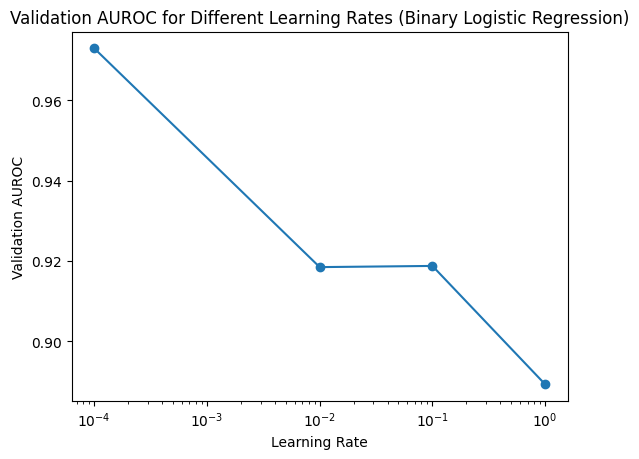

In [ ]:
# using all features

# splitting data
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X_cancer, y_cancer, train_size=0.33, valid_size=0.33, test_size=0.34)

# various learning rates
learning_rates = [0.0001, 0.01, 0.1, 1.0]
best_auroc = 0
best_weights = None
best_lr = None
auroc_history = {}

# training logistic with different weight
for lr in learning_rates:
    log_reg = LogisticRegression(learning_rate=lr, max_iters=5000, verbose=False)
    log_reg.fit(X_train, y_train)

    X_valid_bias = np.column_stack([X_valid, np.ones(X_valid.shape[0])]) if log_reg.add_bias else X_valid
    y_valid_pred_prob = logistic(np.dot(X_valid_bias, log_reg.w))


    auroc_valid = roc_auc_score(y_valid, y_valid_pred_prob)
    auroc_history[lr] = auroc_valid

    # keeping track of best weight
    if auroc_valid > best_auroc:
        best_auroc = auroc_valid
        best_weights = log_reg.w.copy()
        best_lr = lr

# logistic regression with best weight
log_reg = LogisticRegression(learning_rate=best_lr, max_iters=5000, verbose=False)
log_reg.w = best_weights

# auroc on test set
X_test_bias = np.column_stack([X_test, np.ones(X_test.shape[0])]) if log_reg.add_bias else X_test
y_test_pred_prob = logistic(np.dot(X_test_bias, log_reg.w))
auroc_test = roc_auc_score(y_test, y_test_pred_prob)

print(f"Best Learning Rate: {best_lr}")
print(f"Best Binary Logistic Regression - Validation AUROC: {best_auroc:.4f}")
print(f"Final Binary Logistic Regression - Test AUROC: {auroc_test:.4f}")

# auroc
plt.plot(learning_rates, list(auroc_history.values()), marker="o")
plt.xlabel("Learning Rate")
plt.xscale("log")
plt.ylabel("Validation AUROC")
plt.title("Validation AUROC for Different Learning Rates (Binary Logistic Regression)")
plt.show()

Best Learning Rate: 0.01
Best Binary Logistic Regression - Validation AUROC: 0.9838
Final Binary Logistic Regression - Test AUROC: 0.9795


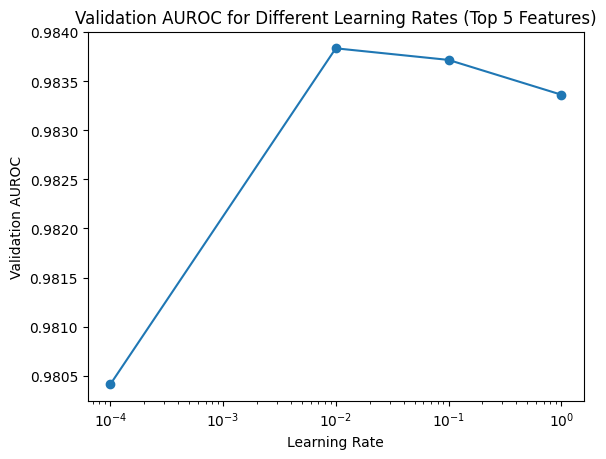

In [ ]:
# using top 5 features

top_5_features = ["Concave_Points_3", "Perimeter_3", "Radius_3", "Perimeter", "Area_3"]
X_cancer_top5 = wdbc_df[top_5_features].copy()

# standardize
X_cancer_top5_standardized = StandardScaler().fit_transform(X_cancer_top5)

# back to data frame
X_cancer_top5_df = pd.DataFrame(X_cancer_top5_standardized, columns=top_5_features)

# target
X_cancer_top5_df["Diagnosis"] = y_cancer.reset_index(drop=True)

# splitting data
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(
    X_cancer_top5_df.drop(columns=["Diagnosis"]),
    X_cancer_top5_df["Diagnosis"],
    train_size=0.33, valid_size=0.33, test_size=0.34
)

# learning rates
learning_rates = [0.0001, 0.01, 0.1, 1.0]
best_auroc = 0
best_weights = None
best_lr = None
auroc_history = {}

# train logistic regression with different learning rates
for lr in learning_rates:
    log_reg = LogisticRegression(learning_rate=lr, max_iters=5000, verbose=False)
    log_reg.fit(X_train, y_train)


    X_valid_bias = np.column_stack([X_valid, np.ones(X_valid.shape[0])]) if log_reg.add_bias else X_valid
    y_valid_pred_prob = logistic(np.dot(X_valid_bias, log_reg.w))

    # auroc
    auroc_valid = roc_auc_score(y_valid, y_valid_pred_prob)
    auroc_history[lr] = auroc_valid

    # best weights
    if auroc_valid > best_auroc:
        best_auroc = auroc_valid
        best_weights = log_reg.w.copy()
        best_lr = lr


log_reg = LogisticRegression(learning_rate=best_lr, max_iters=5000, verbose=False)
log_reg.w = best_weights

X_test_bias = np.column_stack([X_test, np.ones(X_test.shape[0])]) if log_reg.add_bias else X_test
y_test_pred_prob = logistic(np.dot(X_test_bias, log_reg.w))
auroc_test = roc_auc_score(y_test, y_test_pred_prob)

# print
print(f"Best Learning Rate: {best_lr}")
print(f"Best Binary Logistic Regression - Validation AUROC: {best_auroc:.4f}")
print(f"Final Binary Logistic Regression - Test AUROC: {auroc_test:.4f}")

# plot
plt.plot(learning_rates, list(auroc_history.values()), marker="o")
plt.xlabel("Learning Rate")
plt.xscale("log")
plt.ylabel("Validation AUROC")
plt.title("Validation AUROC for Different Learning Rates (Top 5 Features)")
plt.show()

### Compare AUROC and Prediction Accuracy (5) and Draw ROC Curves (6) and Compare Test Accuracies (7)


Binary Classification (Breast Cancer) - Top 5 Features
=== Model Comparison ===
Linear Regression - Accuracy: 0.6031, AUROC: 0.9779
Logistic Regression - Accuracy: 0.9021, AUROC: 0.9795


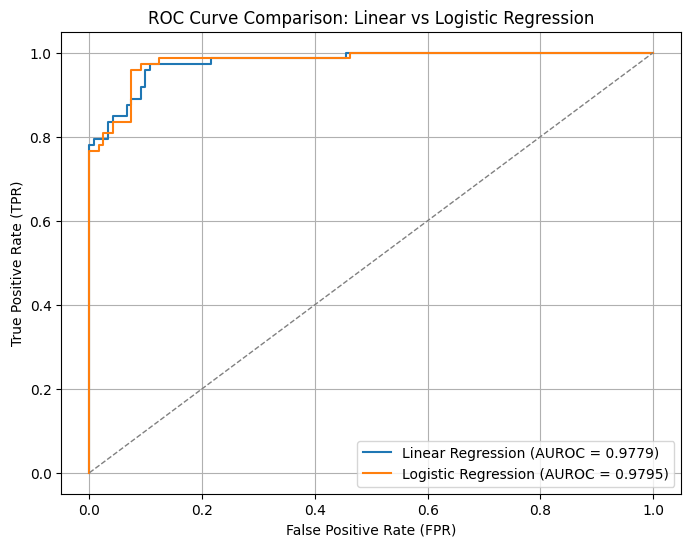

=== Test Accuracies ===
Linear Regression - Accuracy: 0.6031
Logistic Regression - Accuracy: 0.9021


In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

log_reg.fit(X_train, y_train)

# compare linear and logistic regression
print("\nBinary Classification (Breast Cancer) - Top 5 Features")
compare(lin_reg, log_reg, X_test, y_test)

### Compare Coeffs (8)

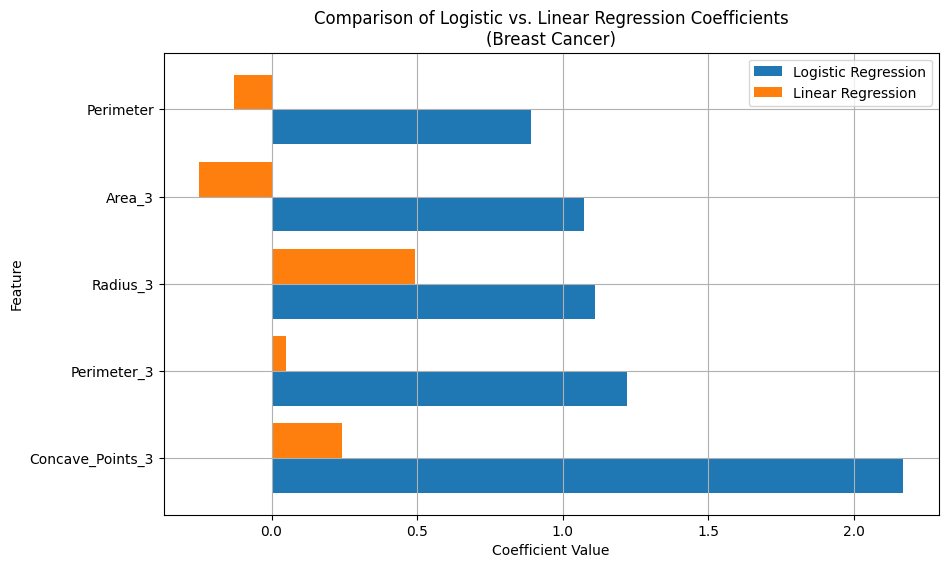


Top Features in Breast Cancer:
                  Logistic Regression Coef  Linear Regression Coef
Feature                                                           
Concave_Points_3                  2.169254                0.242400
Perimeter_3                       1.220037                0.048242
Radius_3                          1.109639                0.492095
Area_3                            1.071436               -0.249448
Perimeter                         0.889060               -0.129409


In [ ]:
compare_coefficients(log_reg_5, lin_reg_5, top_5_features, "Breast Cancer")

## Penguin

### Output Validation AUROC (4)

In [23]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
epsilons = [1e-5, 1e-4, 1e-3]
max_iters_list = [1000, 5000, 10000]

# track best parameters
best_auroc = float('-inf')
best_params = None
best_model = None
results = []

for alpha, epsilon, max_iters in product(learning_rates, epsilons, max_iters_list):

    model = MultinomialLogistic(
        n_features=X_train_p.shape[1],
        n_classes=Y_train_p.shape[1],
        learning_rate=alpha,
        tolerance=epsilon,
        max_iters=max_iters,
        verbose=False
    )

    model.fit(X_train_p, Y_train_p, X_valid_p, Y_valid_p)

    # validation AUROC
    y_valid_pred_probs = model.predict_proba(X_valid_p)

    try:
        auroc_valid = roc_auc_score(Y_valid_p, y_valid_pred_probs, multi_class='ovr')
    except ValueError:
        print(f"Skipping alpha={alpha}, epsilon={epsilon}, max_iters={max_iters} due to AUROC computation error.")
        continue

    # store results
    results.append((alpha, epsilon, max_iters, auroc_valid))
    print(f"Validation AUROC: {auroc_valid:.4f} (alpha={alpha}, epsilon={epsilon}, max_iters={max_iters})")

    # track
    if auroc_valid > best_auroc:
        best_auroc = auroc_valid
        best_params = (alpha, epsilon, max_iters)
        best_model = model

# best model
if best_params:
    print(f"\nBest Parameters: alpha={best_params[0]}, epsilon={best_params[1]}, max_iters={best_params[2]}")
    print(f"Best Validation AUROC: {best_auroc:.4f}")

    final_model = MultinomialLogistic(
        n_features=X_train_p.shape[1],
        n_classes=Y_train_p.shape[1],
        learning_rate=best_params[0],
        tolerance=best_params[1],
        max_iters=best_params[2],
        verbose=True
    )
    final_model.fit(X_train_p, Y_train_p, X_valid_p, Y_valid_p)

    # evaluate on test set
    y_test_pred_probs = final_model.predict_proba(X_test_p)
    try:
        test_auroc = roc_auc_score(Y_test_p, y_test_pred_probs, multi_class='ovr')
        print(f"\nFinal Test AUROC: {test_auroc:.4f}")
    except ValueError:
        print("\nFinal Test AUROC computation failed due to incompatible predictions.")

Validation AUROC: 0.9865 (alpha=0.0001, epsilon=1e-05, max_iters=1000)
Validation AUROC: 0.9976 (alpha=0.0001, epsilon=1e-05, max_iters=5000)
Validation AUROC: 0.9976 (alpha=0.0001, epsilon=1e-05, max_iters=10000)
Validation AUROC: 0.8802 (alpha=0.0001, epsilon=0.0001, max_iters=1000)
Validation AUROC: 0.9976 (alpha=0.0001, epsilon=0.0001, max_iters=5000)
Validation AUROC: 0.9976 (alpha=0.0001, epsilon=0.0001, max_iters=10000)
Validation AUROC: 0.9787 (alpha=0.0001, epsilon=0.001, max_iters=1000)
Validation AUROC: 0.9963 (alpha=0.0001, epsilon=0.001, max_iters=5000)
Validation AUROC: 0.9976 (alpha=0.0001, epsilon=0.001, max_iters=10000)
Validation AUROC: 0.9976 (alpha=0.001, epsilon=1e-05, max_iters=1000)
Validation AUROC: 0.9994 (alpha=0.001, epsilon=1e-05, max_iters=5000)
Validation AUROC: 1.0000 (alpha=0.001, epsilon=1e-05, max_iters=10000)
Validation AUROC: 0.9976 (alpha=0.001, epsilon=0.0001, max_iters=1000)
Validation AUROC: 0.9994 (alpha=0.001, epsilon=0.0001, max_iters=5000)
Va

### Compare AUROC and Prediction Accuracy (5) and Compare Test Accuracies (7)

In [51]:
compare2(multi_lin_reg, final_model, accuracy_mlr, X_test_p, Y_test_p)

=== Model Comparison ===
Linear Regression - Accuracy: 1.0000, AUROC: 0.5000
Logistic Regression - Accuracy: 1.0000, AUROC: 1.0000


### Heatmap (9)

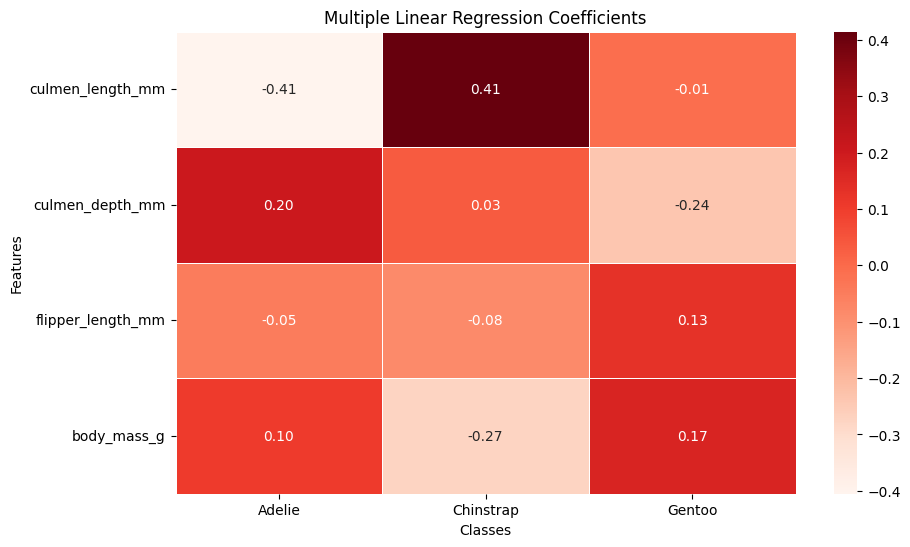

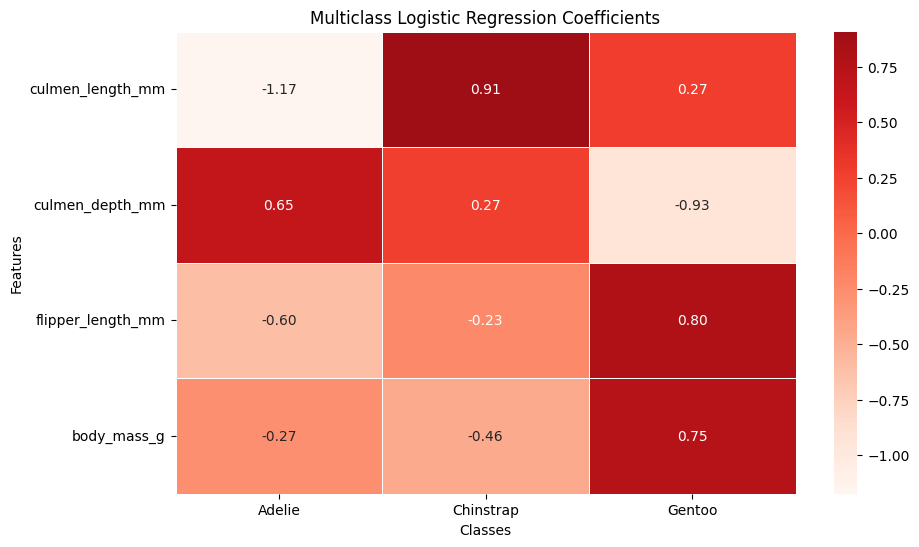

In [ ]:
logistic_coefs = final_model.W
class_names = encoder.categories_[0]
feature_names = list(X_penguin.columns)

linear_coefs = multi_lin_reg.W

# plot
plot_heatmap(linear_coefs, feature_names, class_names, "Multiple Linear Regression Coefficients")
plot_heatmap(logistic_coefs, feature_names, class_names, "Multiclass Logistic Regression Coefficients")

# Task 5: Optional Tasks

## Ridge and LASSO

### Breast Cancer

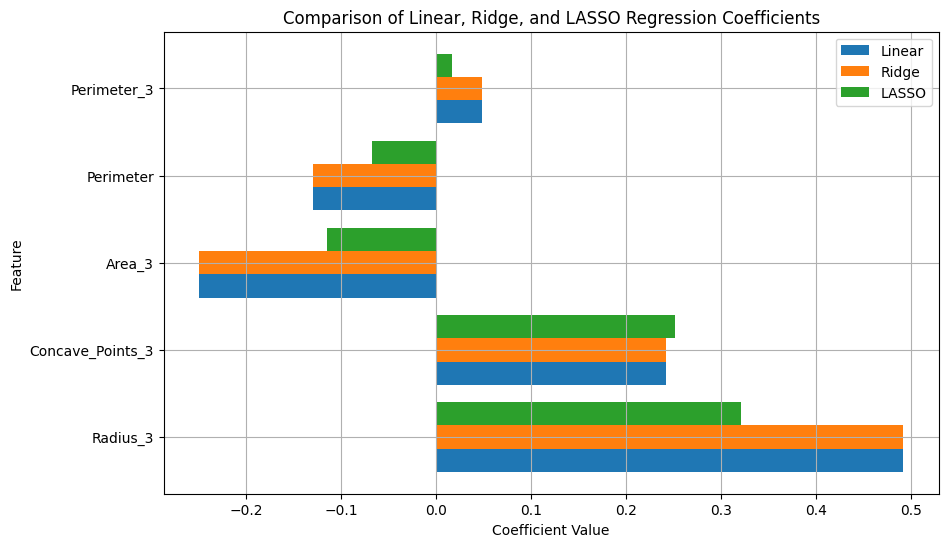

In [ ]:
# decided to use best alpha
alpha = 0.001

# ridge
ridge_reg = Ridge(alpha=alpha)
ridge_reg.fit(X_train, y_train)

# lasso
lasso_reg = Lasso(alpha=alpha)
lasso_reg.fit(X_train, y_train)

# coefficients
ridge_coefs = ridge_reg.coef_
lasso_coefs = lasso_reg.coef_
linear_coefs = lin_reg.W[:-1]

coef_df = pd.DataFrame({
    "Feature": top_5_features,
    "Linear Regression": linear_coefs,
    "Ridge Regression": ridge_coefs,
    "LASSO Regression": lasso_coefs
})

coef_df = coef_df.set_index("Feature").sort_values(by="LASSO Regression", key=np.abs, ascending=False)

# plot
fig, ax = plt.subplots(figsize=(10, 6))
coef_df.plot(kind="barh", ax=ax, width=0.8)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Comparison of Linear, Ridge, and LASSO Regression Coefficients")
plt.legend(["Linear", "Ridge", "LASSO"])
plt.grid(True)
plt.show()

### Penguin

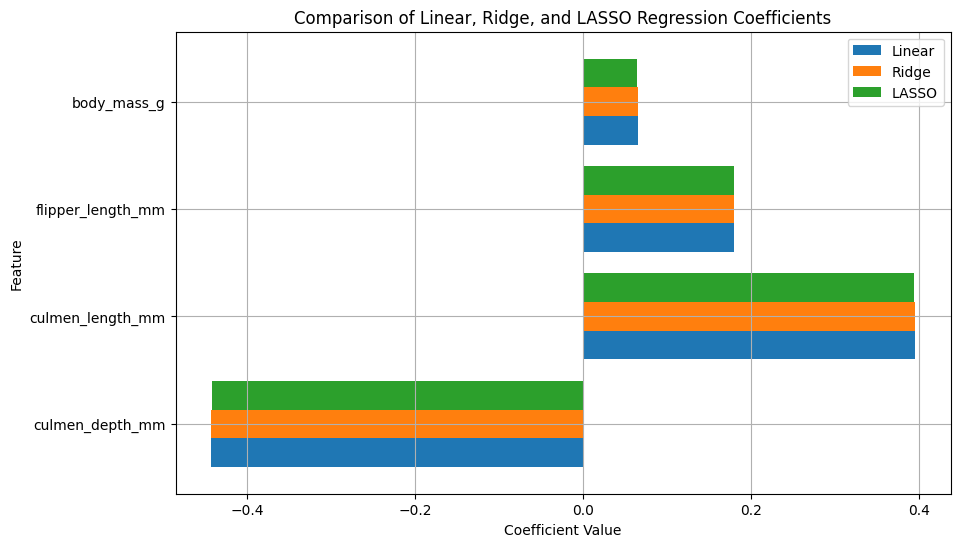

In [ ]:
Y_train_p_single = np.argmax(Y_train_p, axis=1)

# alpha
alpha = 0.001

# ridge
ridge_reg = Ridge(alpha=alpha)
ridge_reg.fit(X_train_p, Y_train_p_single)

# lasso
lasso_reg = Lasso(alpha=alpha)
lasso_reg.fit(X_train_p, Y_train_p_single)

# coeffs
lin_reg = LinearRegression()
lin_reg.fit(X_train_p, Y_train_p_single)
linear_coefs = lin_reg.W[:-1]

coef_df = pd.DataFrame({
    "Feature": ['culmen_length_mm',  'culmen_depth_mm', 'flipper_length_mm',  'body_mass_g'],
    "Linear Regression": linear_coefs,
    "Ridge Regression": ridge_reg.coef_,
    "LASSO Regression": lasso_reg.coef_
})

coef_df = coef_df.set_index("Feature").sort_values(by="LASSO Regression", key=lambda x: np.abs(x), ascending=False)

# plot
fig, ax = plt.subplots(figsize=(10, 6))
coef_df.plot(kind="barh", ax=ax, width=0.8)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Comparison of Linear, Ridge, and LASSO Regression Coefficients")
plt.legend(["Linear", "Ridge", "LASSO"])
plt.grid(True)
plt.show()

## KNN and Decision Tree

### KNN

#### Breast Cancer

In [ ]:
# find best k in knn
best_k = None
best_auroc_knn = 0
k_values = [1, 3, 5, 7, 9, 11]

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_valid_probs = knn.predict_proba(X_valid)[:, 1]

    auroc = roc_auc_score(y_valid, y_valid_probs)

    if auroc > best_auroc_knn:
        best_auroc_knn = auroc
        best_k = k

print(f"Best KNN k-value for Breast Cancer: {best_k} with validation AUROC: {best_auroc_knn:.4f}")

Best KNN k-value for Breast Cancer: 11 with validation AUROC: 0.9749


#### Penguin

In [ ]:
# find best k in knn
best_k = None
best_auroc_knn = 0
k_values = [1, 3, 5, 7, 9, 11]

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_p, Y_train_p.argmax(axis=1))

    y_valid_probs = knn.predict_proba(X_valid_p)

    auroc = roc_auc_score(Y_valid_p, y_valid_probs, multi_class="ovr")

    if auroc > best_auroc_knn:
        best_auroc_knn = auroc
        best_k = k

print(f"Best KNN k-value for Penguins: {best_k} with validation AUROC: {best_auroc_knn:.4f}")

Best KNN k-value for Penguins: 3 with validation AUROC: 1.0000


### Decision Tree

#### Breast Cancer

In [ ]:
# find best dt
best_depth = None
best_auroc_tree = 0
depth_values = [2, 4, 6, 8, 10, 12]

for depth in depth_values:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)

    y_valid_probs = tree.predict_proba(X_valid)[:, 1]

    auroc = roc_auc_score(y_valid, y_valid_probs)

    if auroc > best_auroc_tree:
        best_auroc_tree = auroc
        best_depth = depth

print(f"Best Decision Tree depth for Breast Cancer: {best_depth} with validation AUROC: {best_auroc_tree:.4f}")

Best Decision Tree depth for Breast Cancer: 4 with validation AUROC: 0.9490


#### Penguin

In [ ]:
# find best dt
best_depth = None
best_auroc_tree = 0
depth_values = [2, 4, 6, 8, 10, 12]

for depth in depth_values:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train_p, Y_train_p.argmax(axis=1))

    y_valid_probs = tree.predict_proba(X_valid_p)

    auroc = roc_auc_score(Y_valid_p, y_valid_probs, multi_class="ovr")

    if auroc > best_auroc_tree:
        best_auroc_tree = auroc
        best_depth = depth

print(f"Best Decision Tree depth: {best_depth} with validation AUROC: {best_auroc_tree:.4f}")

Best Decision Tree depth: 2 with validation AUROC: 1.0000


### AUROC

#### Breast Cancer

In [ ]:
# compare knn and decision tree
knn_best = KNeighborsClassifier(n_neighbors=best_k).fit(X_train, y_train)
tree_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42).fit(X_train, y_train)

y_test_probs_knn = knn_best.predict_proba(X_test)[:, 1]
y_test_probs_tree = tree_best.predict_proba(X_test)[:, 1]

knn_auroc = roc_auc_score(y_test, y_test_probs_knn)
tree_auroc = roc_auc_score(y_test, y_test_probs_tree)

print("\n=== Binary Classification (Breast Cancer) ===")
print(f"KNN - AUROC: {knn_auroc:.4f}")
print(f"Decision Tree - AUROC: {tree_auroc:.4f}")


=== Binary Classification (Breast Cancer) ===
KNN - AUROC: 0.9710
Decision Tree - AUROC: 0.9008


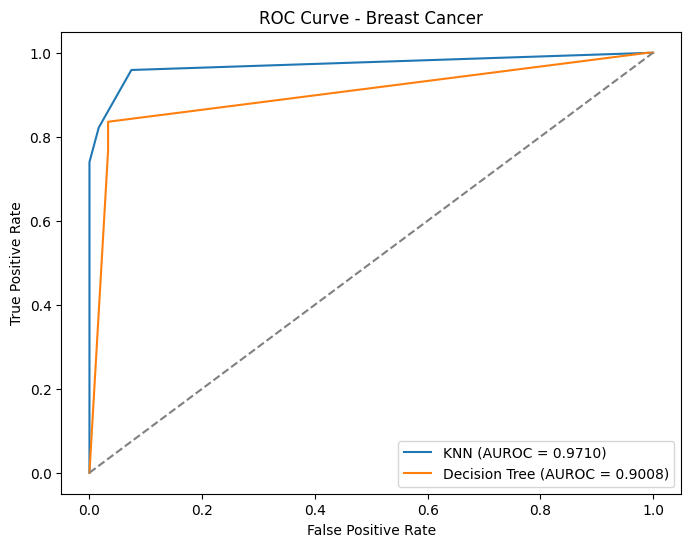

In [ ]:
# roc curve
plt.figure(figsize=(8, 6))
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_best.predict_proba(X_test)[:, 1])
fpr_tree, tpr_tree, _ = roc_curve(y_test, tree_best.predict_proba(X_test)[:, 1])

plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUROC = {knn_auroc:.4f})")
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUROC = {tree_auroc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="dashed")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Breast Cancer")
plt.legend()
plt.show()

#### Penguin

In [ ]:
# compare knn and decision tree
knn_best = KNeighborsClassifier(n_neighbors=best_k).fit(X_train_p, Y_train_p.argmax(axis=1))
tree_best = DecisionTreeClassifier(max_depth=best_depth, random_state=42).fit(X_train_p, Y_train_p.argmax(axis=1))

y_test_probs_knn = knn_best.predict_proba(X_test_p)
y_test_probs_tree = tree_best.predict_proba(X_test_p)

knn_auroc = roc_auc_score(Y_test_p, y_test_probs_knn, multi_class="ovr")
tree_auroc = roc_auc_score(Y_test_p, y_test_probs_tree, multi_class="ovr")

print("\n=== Multi-Class Classification (Penguins) ===")
print(f"KNN - AUROC: {knn_auroc:.4f}")
print(f"Decision Tree - AUROC: {tree_auroc:.4f}")


=== Multi-Class Classification (Penguins) ===
KNN - AUROC: 1.0000
Decision Tree - AUROC: 0.9875


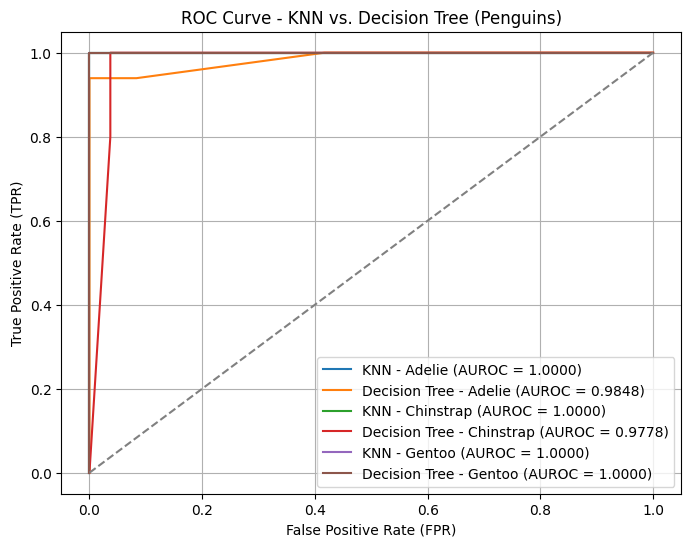

In [ ]:
# roc curve
plt.figure(figsize=(8, 6))

for class_idx, class_name in enumerate(encoder.categories_[0]):
    fpr_knn, tpr_knn, _ = roc_curve(Y_test_p[:, class_idx], y_test_probs_knn[:, class_idx])
    fpr_tree, tpr_tree, _ = roc_curve(Y_test_p[:, class_idx], y_test_probs_tree[:, class_idx])

    plt.plot(fpr_knn, tpr_knn, label=f"KNN - {class_name} (AUROC = {roc_auc_score(Y_test_p[:, class_idx], y_test_probs_knn[:, class_idx]):.4f})", linestyle="-")
    plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree - {class_name} (AUROC = {roc_auc_score(Y_test_p[:, class_idx], y_test_probs_tree[:, class_idx]):.4f})", linestyle="-")

plt.plot([0, 1], [0, 1], color="gray", linestyle="dashed")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - KNN vs. Decision Tree (Penguins)")
plt.legend()
plt.grid()
plt.show()